In [326]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

#Einlesen des verschiedenen Datensätze (Messtellen, GW-Tiefe) und zusammenführen der Datensätze
data = pd.read_csv("Messstellen.csv",delimiter=",")
depth = pd.read_csv("GW_depth.csv", delimiter=',')
data = pd.merge(data,depth,how='left', on='GW-Nummer')
data = data.groupby("GW-Nummer").mean()
data = data.dropna()
data.columns = ['Rechtswert','Hochwert', 'GWHoehe']

In [328]:
#Einlesen des dritten Datensatzes mit chemischen Parametern
GW_data = pd.read_csv('GW_data.csv',delimiter=',')

In [329]:
#Für die erste Hypothese: Aufsplitten der Daten in nördlich und südlich von Karlsruhe anhand des Rechtswertes 
#Karlsruhe : 49.006889, 8.40365
#Alles südlichen Punkte von Karlsruhe 
data_south = data[data.Rechtswert <= 49.006889]
#Alle nördlichen Punkte von Karlsruhe
data_north = data[data.Rechtswert >= 49.006889]

In [331]:
#Zusammenführen der beiden Datensätze
data_south = pd.merge(data_south,GW_data,how='left', on='GW-Nummer')
data_north = pd.merge(data_north,GW_data,how='left', on='GW-Nummer')

In [332]:
#Bereinigung der Datensätze
GWT_north = data_north['T [°C]']
GWT_north = GWT_north.dropna()

GWT_south = data_south['T [°C]']
GWT_south = GWT_south.dropna()

#### Hypothese 1: H0= "Die durchschnittliche Grundwassertemperatur nördlich von Karlsruhe ist höher als südlich von Karlsruhe" 

In [333]:
#Shapiro-Wilk-Test um Normalverteilung der Daten zu überprüfen 
from scipy.stats import shapiro
stat1, p1 = shapiro(GWT_north)
stat2, p2 = shapiro(GWT_south)
print(p1, p2)

7.980912089008218e-23 0.00716520706191659


1# Da der p-Wert deutlich kleiner ist als das Signifikanzniveau ( 𝛼 =0.01), können wir die Nullhypothese, dass die Werte normalverteilt sind, nicht annehmen.
Nun wird der Mann-Whitney U-Test durchgeführt. Die Nullhypothese zu diesem Test lautet, dass die beiden Datensätze die gleiche Verteilung haben. Die alternative Hypothese lautet, dass die Verteilungen nicht gleich sind.


In [334]:
#Mann-Whitney U-Test
U_value, p_value = scipy.stats.mannwhitneyu(GWT_north, GWT_south)
print (U_value, p_value)

22576.0 2.2099904404814013e-10


/Users/markvollmer/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/markvollmer/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


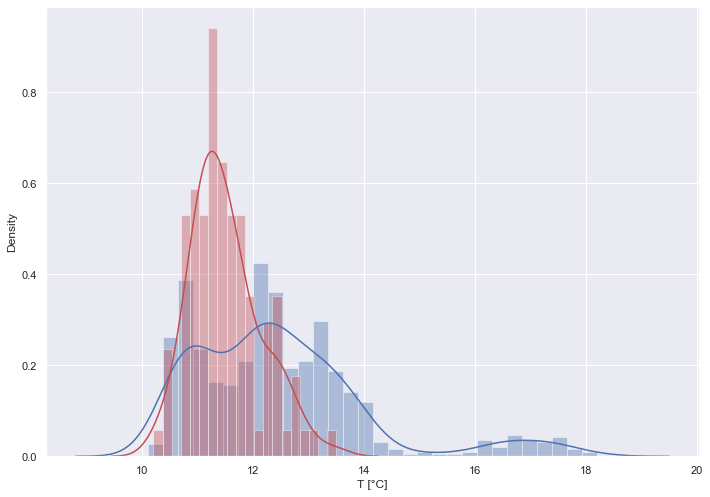

In [335]:
#Um die Verteilungen der Daten zu visualisieren, kann man eine Funktion von Seaborn benutzen
import seaborn as sns 
from scipy.stats import norm
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(GWT_north,bins=30)
sns.distplot(GWT_south, bins=20, color='r')
plt.show()

In [252]:
#Erstellen eines neuen Dataframes für zweite Hypothese
GWT = pd.DataFrame(np.c_[GW_data['GW-Nummer'],GW_data['Messstelle'],GW_data['T [°C]']], columns = ['GW-Nummer','Messstelle','T'])

In [305]:
#Aufteilen des Datensatzes anhand der GW-Nummern für die Stadtwerke und den Campus Nord 
#Nummer : 1112/259-5 Stadtwerke; 0254/258-8 Campus Nord 

SK = GWT["GW-Nummer"] == "1112/259-5"
SK = GWT.loc[SK,:]

CN = GWT["GW-Nummer"] == "0254/258-8"
CN = GWT.loc[CN,:]

#### Hypothese 2 : H0= "Die durchschnittliche Grundwassertemperatur im Stadtgebiet Karlsruhe ist höher als am Campus Nord" 

In [311]:
#two sample t-Test, weil zwei Datensätze miteinander verglichen werden sollen 
#-> für den Test müssen beide Datensätze normalverteilt sein

stat_SK, p_SK = shapiro(SK['T'])
print(p_SK)
stat_CN, p_CN = shapiro(CN['T'])
print(p_CN)

0.0717478096485138
0.10953930765390396


In [312]:
#F-Test zum Testen der Varianzen der beiden Datensätze 
var_SK = statistics.variance(SK['T'])
var_CN = statistics.variance(CN['T'])
if var_SK > var_CN:
    sa = var_SK
    sb = var_CN
else:
    sa = var_CN
    sb = var_SK
F = sa/sb
print (F)

1.0747549019607843


In [313]:
#Für das Testen der Hypothese wird dieser berechnete F-Wert nun mit dem kritischen F-Wert der Fisher-Verteilung verglichen
#p-Wert kann mit dem Signifikanzniveau verglichen werden 
import scipy
dfn = SK['T'].size-1
dfd = CN['T'].size-1
p = 1-scipy.stats.f.cdf(F, dfn, dfd)
print(p)

0.4406949377403554


In [320]:
#Mean-Werte, um die Größenverhältnisse zu checken
#T-Wert und p-Wert berechnen 
mean_t_sk = SK['T'].mean()
mean_t_cn = CN['T'].mean()
t_value, p = stats.ttest_ind(SK['T'],CN['T'])
p = p*0.5
print (t_value, p)

12.578494696646016 1.9372352463939864e-14


In [321]:
#kritischer T-Wert wird berechnet 
df = dfn + dfd 
t_crit = scipy.stats.t.ppf(1-0.05/2, df)
print(t_crit)

2.0345152974493383


► Sauerstoffsättigung normalverteilt ► H0 annehmen
► F=1.07,p=0.44 ► H0annehmen
► T = 12,57, p = 1.97e-14, und T > T_kritisch ► H0 ablehnen

#### Hypothese 3: H0= "Die mittlere Grundwassertemperatur am Campus Nord beträgt 13°C 

In [340]:
#Shapiro Wilk Test zum überprüfen der Normalverteilung
from scipy.stats import shapiro
stat, p = shapiro(CN['T'])
print(p)

0.10953930765390396


1# Da der p-Wert deutlich größer ist als das Signifikanzniveau ($\alpha$=0.01), können wir die Nullhypothese, dass die Werte normalverteilt sind, annehmen

In [346]:
#t-test für die Nullhypothese
from scipy import stats
stat, p = stats.ttest_1samp(CN['T'], 13)
print('stat=%.4f, p=%.4f' % (stat, p))
if p > 0.01:
	print('H0 annehmen')
else:
	print('H0 nicht annehmen')

stat=-5.6667, p=0.0000
H0 nicht annehmen


In [347]:
#Berechnung des Mittelweres und n Anzahl
import statistics
mean_GWT = statistics.mean(CN['T'])
n = len(CN['T'])
print(mean_GWT, n)

12.433333333333334 18


► Temperatur am Campus Nord ► H0 annehmen
► Temperatur = 13°C?  ►  H0 nicht annehmen (p = 0.005)
► Mittelwert Temperatur = 12.43°C, n = 18  Trennschärfe!

#### Hypothese 4 mit anderem Paramter als der Temperatur 

#### H0 = "Chloridgehalt im Hardtwald niedriger als im Stadtzentrum"

In [377]:
#Erstellen von neuem Dataframe mit den benötigten Parametern
GWT = pd.DataFrame(np.c_[GW_data['GW-Nummer'],GW_data['Messstelle'],GW_data['Cl [mg/l]']], columns = ['GW-Nummer','Messstelle','Cl'])

#Aufteilen des Datensatzes anhand der GW-Nummern
#Nummer : 1112/259-5 Stadtwerke, 0920/259-4 Hardtwald
urban = GWT["GW-Nummer"] == "1112/259-5"
urban_cl = GWT.loc[urban,:]
urban_cl =urban_cl.dropna()

forest_cl = GWT["GW-Nummer"] == "0920/259-4"
forest_cl = GWT.loc[forest_cl,:]
forest_cl =forest_cl.dropna()

In [378]:
#Shapiro-Wilk Test
stat_f, p_f = shapiro(urban_cl['Cl'])
print(p_f)

0.23321408033370972


In [379]:
#Shapiro-Wilk Test
stat_f, p_f = shapiro(forest_cl['Cl'])
print(p_f)

0.28472405672073364


In [380]:
#F-Test für beide Parameter 
var_urban_cl = statistics.variance(urban_cl['Cl'])
var_forest_cl = statistics.variance(forest_cl['Cl'])
if var_urban_cl > var_forest_cl:
    sa = var_urban_cl
    sb = var_forest_cl
else:
    sa = var_forest_cl
    sb = var_urban_cl
F = sa/sb
print (F)

7.476815057317598


In [381]:
#kritischer F-Wert
import scipy
dfn = forest_cl['Cl'].size-1
dfd = urban_cl['Cl'].size-1
p = 1-scipy.stats.f.cdf(F, dfn, dfd)
print(p)

0.00993940401887139


In [386]:
#Mean-Werte, um die Größenverhältnisse zu checken
#T-Wert und p-Wert berechnen 
mean_forest = forest_cl['Cl'].mean()
mean_urban = urban_cl['Cl'].mean()
t_value, p = stats.ttest_ind(urban_cl['Cl'],forest_cl['Cl'])
p = p*0.5
print (t_value, p)

3.7078389941668615 0.0014963000196325182


In [387]:
#Berechnung des T-krit 
df = dfn + dfd 
t_crit = scipy.stats.t.ppf(1-0.05/2, df)
print(t_crit)

2.1788128296634177
